## Part I: Data Pre-processing

In [1]:
import pandas as pd

In [2]:
# Download the Google Analogy dataset
!wget http://download.tensorflow.org/data/questions-words.txt

--2024-09-30 04:00:24--  http://download.tensorflow.org/data/questions-words.txt
正在查找主機 download.tensorflow.org (download.tensorflow.org)... 172.217.160.91, 142.250.196.219, 172.217.163.59, ...
正在連接 download.tensorflow.org (download.tensorflow.org)|172.217.160.91|:80... 連上了。
已送出 HTTP 要求，正在等候回應... 200 OK
長度: 603955 (590K) [text/plain]
儲存到：「questions-words.txt.1」

questions-words.txt 100%[===================>] 589.80K  --.-KB/s  於 0.07s      

2024-09-30 04:00:25 (8.38 MB/s) - 已儲存 「questions-words.txt.1」 [603955/603955]



In [3]:
# Preprocess the dataset
file_name = "questions-words"
with open(f"{file_name}.txt", "r") as f:
    data = f.read().splitlines()

In [4]:
# check data from the first 10 entries
for entry in data[:10]:
    print(entry)

: capital-common-countries
Athens Greece Baghdad Iraq
Athens Greece Bangkok Thailand
Athens Greece Beijing China
Athens Greece Berlin Germany
Athens Greece Bern Switzerland
Athens Greece Cairo Egypt
Athens Greece Canberra Australia
Athens Greece Hanoi Vietnam
Athens Greece Havana Cuba


In [5]:
# TODO1: Write your code here for processing data to pd.DataFrame
# Please note that the first five mentions of ": " indicate `semantic`,
# and the remaining nine belong to the `syntatic` category.

# Create DataFrame
questions = []
categories = []
sub_categories = []
semantic_count = 0
now_sub = ""
for question in data:
    if ":" in question:
        now_sub = question
        semantic_count += 1
        continue  

    questions.append(question)
    if semantic_count <= 5:
        categories.append("Semantic")
    else:
        categories.append("Syntactic")
    
    sub_categories.append(now_sub)




In [6]:
# Create the dataframe
df = pd.DataFrame(
    {
        "Question": questions,
        "Category": categories,
        "SubCategory": sub_categories,
    }
)

In [7]:
df.head()

,Question,Category,SubCategory
0,Athens Greece Baghdad Iraq,Semantic,: capital-common-countries
1,Athens Greece Bangkok Thailand,Semantic,: capital-common-countries
2,Athens Greece Beijing China,Semantic,: capital-common-countries
3,Athens Greece Berlin Germany,Semantic,: capital-common-countries
4,Athens Greece Bern Switzerland,Semantic,: capital-common-countries


In [8]:
df.to_csv(f"{file_name}.csv", index=False)

# 然後我用difflib比對檔案內容是否與老師給的csv一樣

## Part II: Use pre-trained word embeddings
- After finish Part I, you can run Part II code blocks only.

In [9]:
import pandas as pd
import numpy as np
import gensim.downloader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/hsuan/Downloads/自然語言/assignment 1/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/var/folders/08/lphnfl813k19sjwqqlkgyfsr0000gn/T/ipykernel_6623/996662960.py", line 3, in <module>
    import gensim.downloader
  File "/Users/hsuan/Downloads/自然語言/assignment 1/.venv/lib/python3.12/site-packages/gensim/__init__.py", line 11, in <module>
  File "/Users/hsuan/Downloads/自然語言/assignment 1/.venv/lib/python3.12/site-packages/gensim/corpora/__init__.py", line 6, in <module>
  File "/Users/hsuan/Downloads/自然語言/assignment 1/.venv/lib/python3.12/site-packages/gensim/corpora/indexedcorpus.py", line 14, in <module>
  File "/Users/hsuan/Downloads/自然語言/assignment 1/.venv/lib/python3.12/site-packages/gensim/interfaces.py", line 19, in <module>
  File "/Users/hsuan/Downloads/自然語言/assignment 1/.venv/lib/python3.12/site-packages/gensim/matutils.py", line 19, in <module>
  File "/Users/hsuan/Downloads/自然語言

In [19]:
data = pd.read_csv("questions-words.csv")

In [39]:
MODEL_NAME = "word2vec-google-news-300"
# You can try other models.
# https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models

# Load the pre-trained model (using GloVe vectors here)
model = gensim.downloader.load(MODEL_NAME)
print("The Gensim model loaded successfully!")

The Gensim model loaded successfully!


In [40]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []

for analogy in tqdm(data["Question"]):
      # TODO2: Write your code here to use pre-trained word embeddings for getting predictions of the analogy task.
      # You should also preserve the gold answers during iterations for evaluations later.
      """ Hints
      # Unpack the analogy (e.g., "man", "woman", "king", "queen")
      # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
      # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
      # Mikolov et al., 2013: big - biggest and small - smallest
      # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
      """
      words = analogy.split(" ")

      word_a = words[0]
      word_b = words[1]
      word_c = words[2]
      word_d = words[3]

      try:
          predicted_word = model.most_similar(positive=[word_b, word_c], negative=[word_a], topn=1)[0][0]
      except:
          predicted_word = None

      preds.append(predicted_word)
      golds.append(word_d)


100%|██████████| 19544/19544 [25:52<00:00, 12.59it/s]


In [52]:
# Perform evaluations. You do not need to modify this block!!

def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred)

golds_np, preds_np = np.array(golds), np.array(preds)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: Semantic, Accuracy: 73.08602999210734%
Category: Syntactic, Accuracy: 74.00468384074942%
Sub-Category: capital-common-countries, Accuracy: 83.20158102766798%
Sub-Category: capital-world, Accuracy: 79.13351016799292%
Sub-Category: currency, Accuracy: 35.10392609699769%
Sub-Category: city-in-state, Accuracy: 70.89582488852858%
Sub-Category: family, Accuracy: 84.58498023715416%
Sub-Category: gram1-adjective-to-adverb, Accuracy: 28.528225806451612%
Sub-Category: gram2-opposite, Accuracy: 42.73399014778325%
Sub-Category: gram3-comparative, Accuracy: 90.84084084084084%
Sub-Category: gram4-superlative, Accuracy: 87.34402852049911%
Sub-Category: gram5-present-participle, Accuracy: 78.125%
Sub-Category: gram6-nationality-adjective, Accuracy: 89.93120700437774%
Sub-Category: gram7-past-tense, Accuracy: 65.96153846153847%
Sub-Category: gram8-plural, Accuracy: 89.86486486486487%
Sub-Category: gram9-plural-verbs, Accuracy: 67.93103448275862%


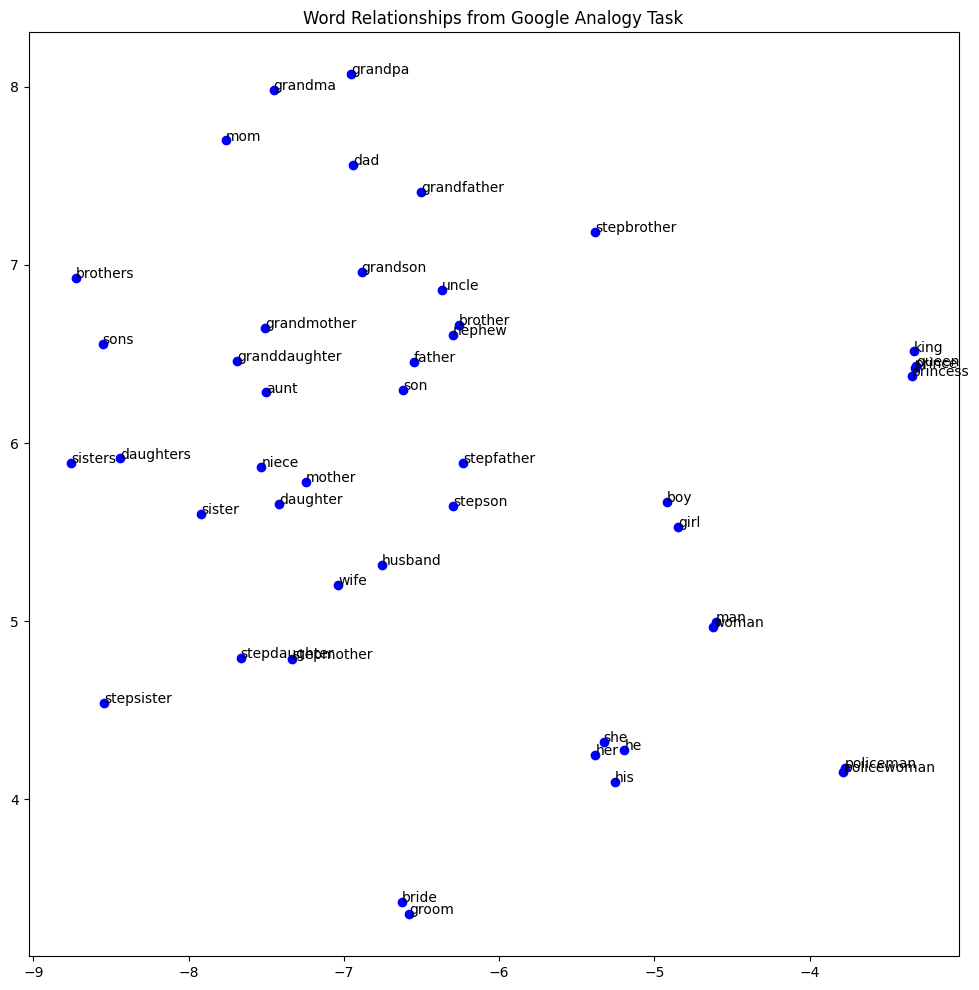

In [53]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# TODO3: Plot t-SNE for the words in the SUB_CATEGORY `: family`
# 篩出family的資料
sub_category_data = data[data["SubCategory"] == SUB_CATEGORY]

# 拆分出Question的單字
words_in_category = set(sub_category_data["Question"].apply(lambda x: x.lower().split(" ")).sum())

# 儲存提取出的詞向量
word_vectors = []

#  檢查每個單字是否在模型中
for word in words_in_category:
    if word in model:
        word_vectors.append(model[word])
    else:
        print(f"Word '{word}' not found in model vocabulary.")

# 將詞向量轉換為NumPy陣列
word_vectors = np.array(word_vectors)

# 使用t-SNE將詞向量降維到2D
tsne = TSNE(n_components=2, random_state=0, perplexity=26)#perplexity根據資料量調整
word_vectors_2d = tsne.fit_transform(word_vectors)


plt.figure(figsize=(12, 12))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], color='blue')

# 標記每個單字
for i, word in enumerate(words_in_category):
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize=10)



plt.title("Word Relationships from Google Analogy Task")
plt.savefig("word_relationships.png", bbox_inches="tight")
plt.show()

### Part III: Train your own word embeddings

### Get the latest English Wikipedia articles and do sampling.
- Usually, we start from Wikipedia dump (https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2). However, the downloading step will take very long. Also, the cleaning step for the Wikipedia corpus ([`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus)) will take much time. Therefore, we provide cleaned files for you.

In [38]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles).
!gdown --id 1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd -O wiki_texts_part_0.txt.gz
!gdown --id 1ABblLRd9HXdXvaNv8H9fFq984bhnowoG -O wiki_texts_part_1.txt.gz
!gdown --id 1z2VFNhpPvCejTP5zyejzKj5YjI_Bn42M -O wiki_texts_part_2.txt.gz
!gdown --id 1VKjded9BxADRhIoCzXy_W8uzVOTWIf0g -O wiki_texts_part_3.txt.gz
!gdown --id 16mBeG26m9LzHXdPe8UrijUIc6sHxhknz -O wiki_texts_part_4.txt.gz

/Users/hsuan/Downloads/自然語言/assignment 1/.venv/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd
From (redirected): https://drive.google.com/uc?id=1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd&confirm=t&uuid=d8b45e2e-8974-4209-9474-3a258032529f
To: /Users/hsuan/Downloads/自然語言/assignment 1/wiki_texts_part_0.txt.gz
100%|██████████████████████████████████████| 1.51G/1.51G [02:41<00:00, 9.33MB/s]
/Users/hsuan/Downloads/自然語言/assignment 1/.venv/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ABblLRd9HXdXvaNv8H9fFq984bhnowoG
From 

In [1]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles), except the last file.
!gdown --id 17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI -O wiki_texts_part_5.txt.gz
!gdown --id 19IvB2vOJRGlrYulnTXlZECR8zT5v550P -O wiki_texts_part_6.txt.gz
!gdown --id 1sjwO8A2SDOKruv6-8NEq7pEIuQ50ygVV -O wiki_texts_part_7.txt.gz
!gdown --id 1s7xKWJmyk98Jbq6Fi1scrHy7fr_ellUX -O wiki_texts_part_8.txt.gz
!gdown --id 17eQXcrvY1cfpKelLbP2BhQKrljnFNykr -O wiki_texts_part_9.txt.gz
!gdown --id 1J5TAN6bNBiSgTIYiPwzmABvGhAF58h62 -O wiki_texts_part_10.txt.gz

/Users/hsuan/Downloads/自然語言/assignment 1/.venv/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI
From (redirected): https://drive.google.com/uc?id=17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI&confirm=t&uuid=ae5f1ac4-ffe3-4e75-8e49-f6cc61667395
To: /Users/hsuan/Downloads/自然語言/assignment 1/wiki_texts_part_5.txt.gz
100%|████████████████████████████████████████| 578M/578M [01:01<00:00, 9.38MB/s]
/Users/hsuan/Downloads/自然語言/assignment 1/.venv/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=19IvB2vOJRGlrYulnTXlZECR8zT5v550P
From 

In [77]:
# Extract the downloaded wiki_texts_parts files.
!gunzip -k wiki_texts_part_*.gz

In [78]:
# Combine the extracted wiki_texts_parts files.
!cat wiki_texts_part_*.txt > wiki_texts_combined.txt

In [79]:
# Check the first ten lines of the combined file
!head -n 10 wiki_texts_combined.txt

anarchism is political philosophy and movement that is against all forms of authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hierarchy typically including the state and capitalism anarchism advocates for the replacement of the state with stateless societies and voluntary free associations as historically left wing movement this reading of anarchism is placed on the farthest left of the political spectrum usually described as the libertarian wing of the socialist movement libertarian socialism although traces of anarchist ideas are found all throughout history modern anarchism emerged from the enlightenment during the latter half of the th and the first decades of the th century the anarchist movement flourished in most parts of the world and had significant role in workers struggles for emancipation various anarchist schools of thought formed during this period anarchists have taken part in several revolutions most notably in the paris commune

Please note that we used the default parameters of [`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus) for cleaning the Wiki raw file. Thus, words with one character were discarded.

In [2]:
# Now you need to do sampling because the corpus is too big.
# You can further perform analysis with a greater sampling ratio.

import random

wiki_txt_path = "wiki_texts_combined.txt"
output_file = "sampled_wiki_texts.txt"
# wiki_texts_combined.txt is a text file separated by linebreaks (\n).
# Each row in wiki_texts_combined.txt indicates a Wikipedia article.

with open(wiki_txt_path, "r", encoding="utf-8") as f:
    with open(output_file, "w", encoding="utf-8") as output_file:
    # TODO4: Sample `20%` Wikipedia articles
    # Write your code here
        lines = f.readlines()
        sampled_lines = random.sample(lines, int(len(lines) * 0.2))
        output_file.writelines(sampled_lines)



In [1]:
# TODO5: Train your own word embeddings with the sampled articles
# https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
# Hint: You should perform some pre-processing before training.

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from langdetect import detect
import string
import nltk


nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')  # 用於詞形還原
nltk.download('omw-1.4')  # 用於支持 WordNet 的多語言詞形還原

# 定義文件路徑
sampled_wiki_txt_path = "sampled_wiki_texts.txt"
processed_wiki_txt_path = "processed_wiki_texts.txt"

# 加載停用詞和詞形還原器
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# 預處理函數
def preprocess(text):
    try:
        # 移除非英語文本
        if detect(text) != 'en':
            return []
    except:
        return []

    # 分詞
    tokens = word_tokenize(text)

    lowercase_tokens = [word.lower() for word in tokens]
    filtered_tokens = [word for word in lowercase_tokens if word not in stop_words and word not in string.punctuation]
    tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]

    return tokens

# 處理好保存到新文件
with open(sampled_wiki_txt_path, "r", encoding="utf-8") as f_in, open(processed_wiki_txt_path, "w", encoding="utf-8") as f_out:
    for line in f_in:
        processed_line = preprocess(line)
        if processed_line:  
            f_out.write(' '.join(processed_line) + '\n')


[nltk_data] Downloading package stopwords to /Users/hsuan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/hsuan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/hsuan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/hsuan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

# 定義處理後的文件路徑
processed_wiki_txt_path = "processed_wiki_texts.txt"

# 使用 LineSentence 逐行讀取處理後的文本
sentences = LineSentence(processed_wiki_txt_path)

# 訓練 Word2Vec 模型
model = Word2Vec(
    sentences=sentences,   # 使用預處理過的句子
    vector_size=100,       # 向量維度
    window=5,              # 上下文窗口大小
    min_count=5,           # 忽略總頻率小於5的單詞
    workers=4,             # 加速
    sg=1,                  # 使用Skip-gram（比較適合大型資料集）
    hs=1,                  # 使用層次軟最大化（加速）
    epochs=10,              # 訓練迭代次數
    compute_loss=True      # 計算損失
)

# 保存模型
model.save("word2vec.model")

print("Word2Vec model trained and saved as 'word2vec.model'")


Word2Vec model trained and saved as 'word2vec.model'


In [15]:
import pandas as pd
data = pd.read_csv("questions-words.csv")


In [54]:
# Do predictions and preserve the gold answers (word_D)
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

preds = []
golds = []

# 載入模型
model = Word2Vec.load("word2vec.model")
model=model.wv

for analogy in tqdm(data["Question"]):
      # TODO6: Write your code here to use your trained word embeddings for getting predictions of the analogy task.
      # You should also preserve the gold answers during iterations for evaluations later.
      """ Hints
      # Unpack the analogy (e.g., "man", "woman", "king", "queen")
      # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
      # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
      # Mikolov et al., 2013: big - biggest and small - smallest
      # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
      """
      words = analogy.split(" ")

      word_a = words[0]
      word_b = words[1]
      word_c = words[2]
      word_d = words[3]

      try:
          predicted_word = model.most_similar(positive=[word_b, word_c], negative=[word_a], topn=1)[0][0]
      except:
          predicted_word = None

      preds.append(predicted_word)
      golds.append(word_d)

100%|██████████| 19544/19544 [02:03<00:00, 158.04it/s] 


In [55]:
# Perform evaluations. You do not need to modify this block!!

def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred)

golds_np, preds_np = np.array(golds), np.array(preds)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: Semantic, Accuracy: 2.277596121321457%
Category: Syntactic, Accuracy: 18.42622950819672%
Sub-Category: capital-common-countries, Accuracy: 0.0%
Sub-Category: capital-world, Accuracy: 0.0%
Sub-Category: currency, Accuracy: 0.0%
Sub-Category: city-in-state, Accuracy: 0.0%
Sub-Category: family, Accuracy: 39.920948616600796%
Sub-Category: gram1-adjective-to-adverb, Accuracy: 17.137096774193548%
Sub-Category: gram2-opposite, Accuracy: 11.576354679802956%
Sub-Category: gram3-comparative, Accuracy: 32.207207207207205%
Sub-Category: gram4-superlative, Accuracy: 13.725490196078432%
Sub-Category: gram5-present-participle, Accuracy: 38.35227272727273%
Sub-Category: gram6-nationality-adjective, Accuracy: 0.0%
Sub-Category: gram7-past-tense, Accuracy: 39.294871794871796%
Sub-Category: gram8-plural, Accuracy: 0.0%
Sub-Category: gram9-plural-verbs, Accuracy: 11.724137931034482%


Word 'daughters' not found.
Word 'his' not found.
Word 'her' not found.
Word 'sons' not found.
Word 'she' not found.
Word 'brothers' not found.
Word 'sisters' not found.


/Users/hsuan/Downloads/自然語言/assignment 1/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


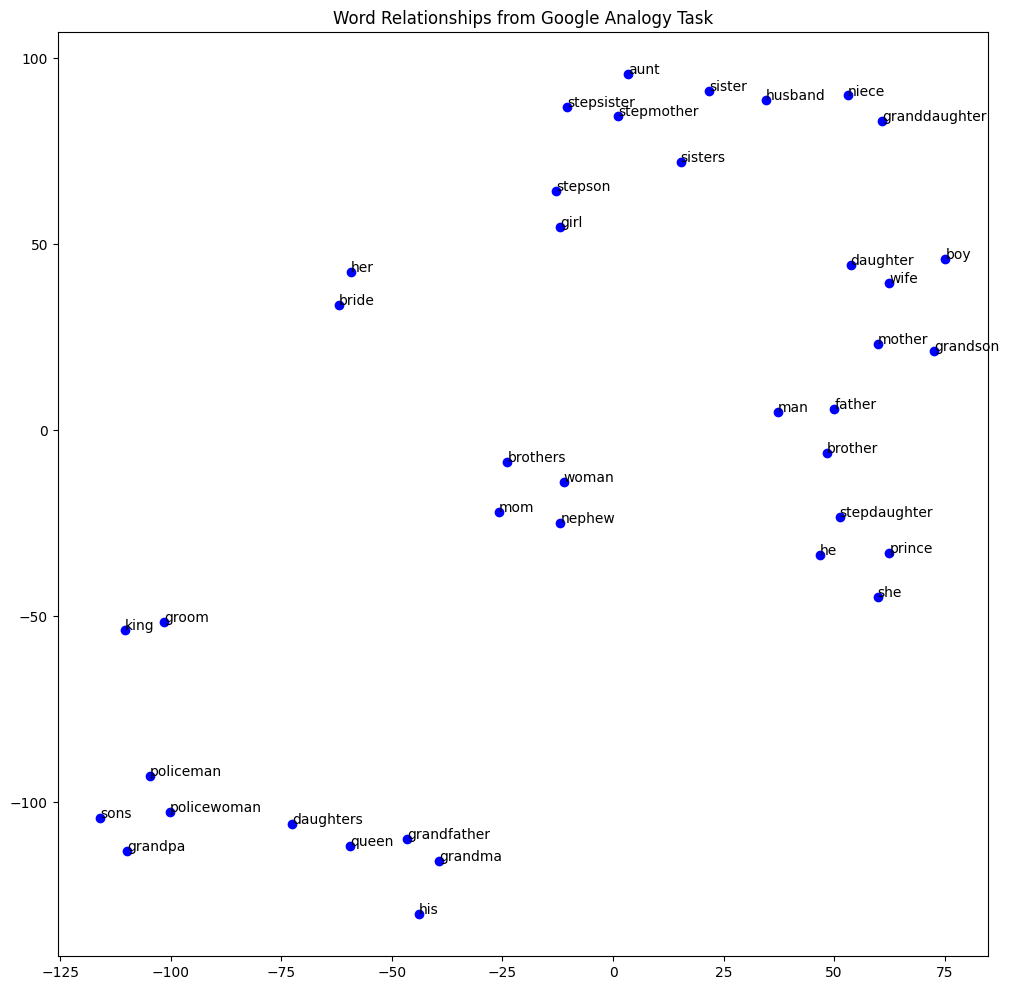

In [63]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# TODO7: Plot t-SNE for the words in the SUB_CATEGORY `: family`
# 篩選出行
sub_category_data = data[data["SubCategory"] == SUB_CATEGORY]

# 拆分出Question的單字
words_in_category = set(sub_category_data["Question"].apply(lambda x: x.split(" ")).sum())

# 儲存提取出的詞向量
word_vectors = []

#  逐一檢查每個單字是否在模型中
for word in words_in_category:
    if word in model:
        word_vectors.append(model[word])
    else:
        print(f"Word '{word}' not found.")

word_vectors = np.array(word_vectors)

# 降維到2D
tsne = TSNE(n_components=2, random_state=42,perplexity=5, n_iter=1000)
word_vectors_2d = tsne.fit_transform(word_vectors)


plt.figure(figsize=(12, 12))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], color='blue')

# 標記每個單字
for i, word in enumerate(list(words_in_category)[:len(word_vectors_2d)]):
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize=10)

plt.title("Word Relationships from Google Analogy Task")
plt.savefig("word_relationships2.png", bbox_inches="tight")
plt.show()